In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

In [2]:
# 1. Загрузка датасета
data = pd.read_csv("IPG3113N.csv", parse_dates=["observation_date"])
data = data.dropna()
data["IPG3113N"] = pd.to_numeric(data["IPG3113N"], errors="coerce")
data.dropna(inplace=True)

  observation_date  IPG3113N
0       1972-01-01   74.6523
1       1972-02-01   62.5670
2       1972-03-01   57.5153
3       1972-04-01   56.2438
4       1972-05-01   56.6303
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636 entries, 0 to 635
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   observation_date  636 non-null    datetime64[ns]
 1   IPG3113N          636 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 10.1 KB
None


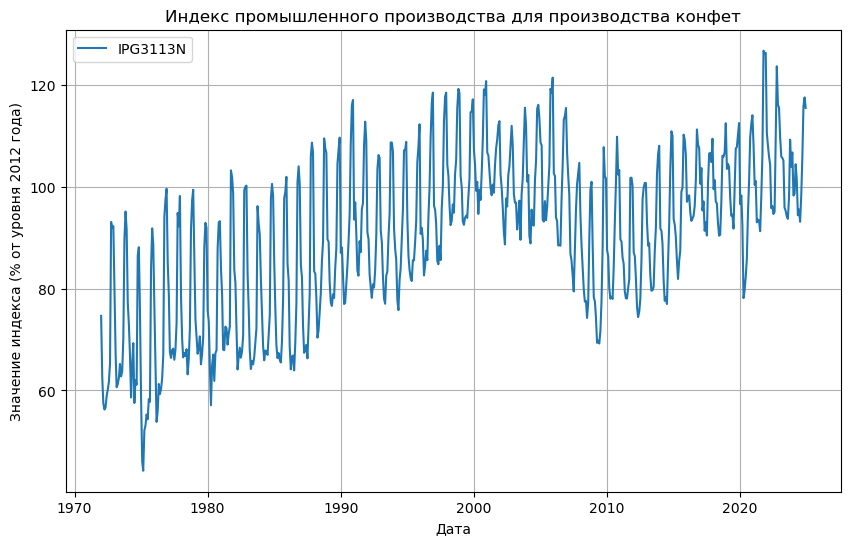

In [3]:
# 2. Исследование данных
print(data.head())  # Вывод первых строк датасета
print(data.info())  # Информация о данных

# Построение графика временного ряда
plt.figure(figsize=(10, 6))
plt.plot(data["observation_date"], data["IPG3113N"], label="IPG3113N")
plt.title("Индекс промышленного производства для производства конфет")
plt.xlabel("Дата")
plt.ylabel("Значение индекса (% от уровня 2012 года)")
plt.legend()
plt.grid()
plt.show()

In [4]:
# 3. Предварительная обработка данных
# Нормализация данных для обучения нейронной сети
scaler = MinMaxScaler()
data["Normalized"] = scaler.fit_transform(data[["IPG3113N"]])

# Преобразование данных в формат для обучения модели (supervised learning)
def create_supervised_data(series, look_back):
    X, y = [], []
    for i in range(len(series) - look_back):
        X.append(series[i:i + look_back])
        y.append(series[i + look_back])
    return np.array(X), np.array(y)

look_back = 24  # Используем последние 24 месяца для прогнозирования следующего месяца
series = data["Normalized"].values
X, y = create_supervised_data(series, look_back)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


In [5]:
# 4. Выбор модели регрессии (MLPRegressor)
# Обоснование: Нейронные сети подходят для выявления сложных закономерностей во временных рядах.

# 5. Выбор метрики оценки качества модели
# Метрики: Среднеквадратичная ошибка (MSE) и Средняя абсолютная ошибка (MAE)
# Обоснование: Эти метрики стандартны для задач регрессии и измеряют отклонение прогнозов от фактических значений.


In [6]:
# 6. Обучение и тестирование модели с подбором гиперпараметров
hidden_layer_sizes = [(50,), (100,), (100, 50)]  # Различные конфигурации скрытых слоёв
learning_rates = [0.001, 0.01]  # Различные скорости обучения
max_iter = 200  # Максимальное количество итераций
best_model = None
best_mse = float("inf")  # Инициализация лучшей MSE как бесконечности

# Перебор гиперпараметров
for hls in hidden_layer_sizes:
    for lr in learning_rates:
        model = MLPRegressor(hidden_layer_sizes=hls, learning_rate_init=lr, max_iter=max_iter, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        if mse < best_mse:
            best_mse = mse
            best_model = model
        print(f"Скрытые слои: {hls}, Скорость обучения: {lr}, MSE: {mse:.4f}")


Скрытые слои: (50,), Скорость обучения: 0.001, MSE: 0.0061
Скрытые слои: (50,), Скорость обучения: 0.01, MSE: 0.0049
Скрытые слои: (100,), Скорость обучения: 0.001, MSE: 0.0041
Скрытые слои: (100,), Скорость обучения: 0.01, MSE: 0.0044
Скрытые слои: (100, 50), Скорость обучения: 0.001, MSE: 0.0031
Скрытые слои: (100, 50), Скорость обучения: 0.01, MSE: 0.0033


In [7]:
# 7. Оценка лучшей модели
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Лучшая модель MSE: {best_mse:.4f}, MAE: {mae:.4f}")


Лучшая модель MSE: 0.0031, MAE: 0.0440


In [8]:
# 8. Прогнозирование будущих значений с использованием лучшей модели
future_steps = 24  # Горизонт прогнозирования: 24 месяца
last_data = series[-look_back:]  # Используем последние `look_back` точки для предсказания
future_predictions = []

for _ in range(future_steps):
    next_pred = best_model.predict(last_data.reshape(1, -1))[0]
    future_predictions.append(next_pred)
    last_data = np.append(last_data[1:], next_pred)

# Обратное преобразование прогнозов к исходному масштабу
future_predictions_rescaled = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()

# Создание диапазона дат для прогноза
forecast_dates = pd.date_range(start=data["observation_date"].iloc[-1] + pd.DateOffset(months=1), periods=future_steps, freq='MS')


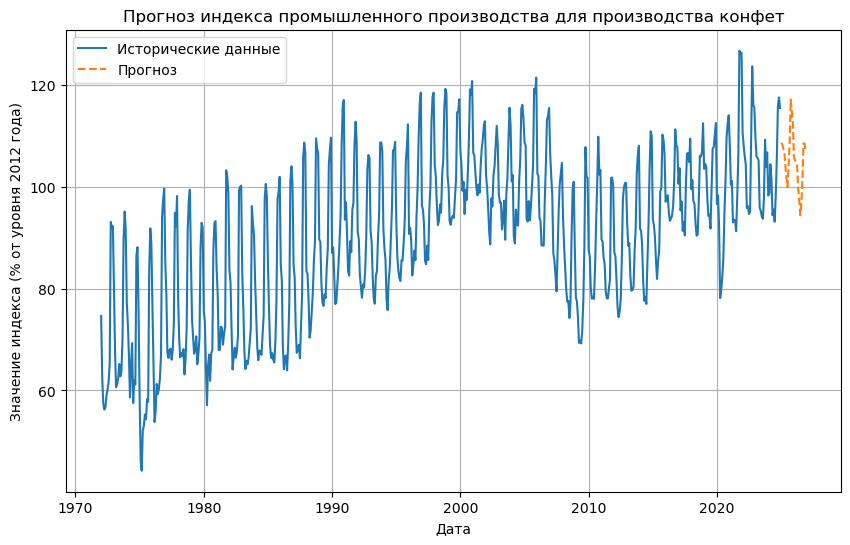

In [9]:
# Построение графика результатов
plt.figure(figsize=(10, 6))
plt.plot(data["observation_date"], data["IPG3113N"], label="Исторические данные")
plt.plot(forecast_dates, future_predictions_rescaled, label="Прогноз", linestyle="--")
plt.title("Прогноз индекса промышленного производства для производства конфет")
plt.xlabel("Дата")
plt.ylabel("Значение индекса (% от уровня 2012 года)")
plt.legend()
plt.grid()
plt.show()
